General optimizations:
- Diro2C generation algorithm could take into account possible values for categorical features or integer features
- scikit-learn Decision tree implementation does not support categorical values, they are currently only approximated by converting them to numbers. Look into alternative implementations or encode values
- it would be better for the understanding, to see how rules evolve with increasing max depth. I used unix diff for that
- general rule for determining, how far to increase max depth parameter

In [13]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, train_surrogate_tree, plot_surrogate_tree,\
                           extract_rules, print_rules, evaluate_generated_data,\
                           evaluate, plot_tree_leafs_2d, plot_diro2c_2d, get_surrogate_tree,\
                           get_feature_importances, plot_feature_importances, set_generated_data,\
                           search_max_depth_parameter
from util import RuleClassifier, evaluate_counterfactual_fidelity, print_complexity
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
with open('task_without_noise.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Explanations

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

## $(False, True)$

In [5]:
focus_class = '(False, True)'
focus_class_idx = list(comparer.class_names).index(focus_class)
y_true = mclass_diff == focus_class_idx

In [6]:
explainer = WrappedDiro2C(X, comparer, focus_class)

Let's first check how long it takes to generate a data set for a single instance:

In [13]:
%%time
_ = explainer.generate_local_explanation(idx_explain=0)

CPU times: user 11min 29s, sys: 37.7 s, total: 12min 7s
Wall time: 3min 31s


In [14]:
((3*60 + 31) * len(X))/60/60

57.26305555555555

In [11]:
%%time
_ = explainer.generate_local_explanation(idx_explain=0, gn_population_size=500)

CPU times: user 1min 6s, sys: 4.77 s, total: 1min 11s
Wall time: 21 s


In [12]:
(21 * len(X))/60/60

5.699166666666667

Even with a reduced population size parameter it still would take more than 5 hours to generate data sets for all instances. I'll use a different approach, where the final data set is built from the merged generated data sets created for only the instances classified differently, but with the default population size parameter. This way, I expect the algorithm to generate instances near to the already known differences.

In [7]:
instance_indices = np.where(y_true)[0]

In [8]:
%%time
explanations = []
for i, instance_idx in enumerate(instance_indices, 1):
    print(f'{i}/{len(instance_indices)}')
    explanation = explainer.generate_local_explanation(instance_idx)
    explanations.append(explanation)
with open(f'diro2c.{focus_class}.pickle', 'wb') as f:
    pickle.dump((explainer, explanations), f, pickle.HIGHEST_PROTOCOL)

1/12
2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
12/12
CPU times: user 2h 14min 22s, sys: 7min 21s, total: 2h 21min 44s
Wall time: 40min 33s


In [6]:
with open(f'diro2c.{focus_class}.pickle', 'rb') as f:
    explainer, explanations = pickle.load(f)

In [7]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

In [8]:
X_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['X']
                            for explanation in explanations])
y_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['y']
                            for explanation in explanations])

In [9]:
explanation = explanations[0]
set_generated_data(explanation, X_explain, y_explain)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


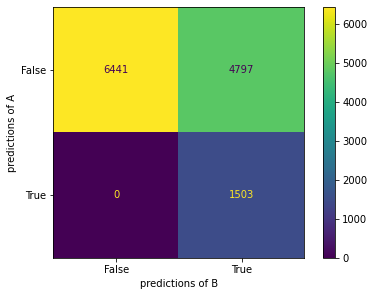

In [10]:
comparer.plot_confusion_matrix(X_explain)

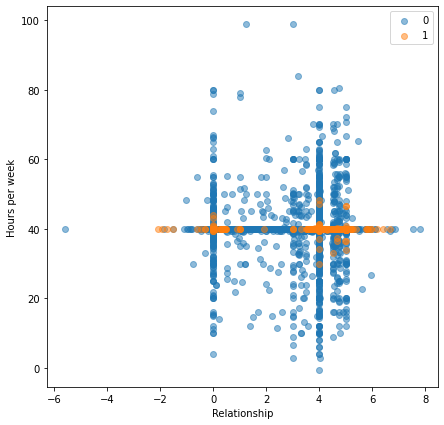

In [11]:
plot_diro2c_2d(explanation, 'Relationship', 'Hours per week')

### Find Optimal Solution

In [14]:
%%time
metrics = search_max_depth_parameter(explanation, X, y_true=y_true)

CPU times: user 23.9 s, sys: 239 ms, total: 24.2 s
Wall time: 25.9 s


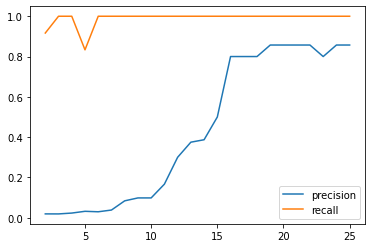

In [15]:
metrics.loc[:, ('precision', 'recall')].plot();

Parameter setting 4 is the one with the highest precision among the settings that achieve perfect recall and have a low number of rules (2). It will serve as the global explanation.

For the local explanations, we could go as far as max depth 16, which yields seven rules and has 80\% precision. But 95 constraints in total are not human-friendly. Precision increases steeply for the first time up to max depth 12, which consists of four rules and 45 constraints.

In [87]:
metrics[(metrics['recall'] > 0.99) & (metrics['rules'] <= 7)]

,precision,recall,rules,constraints
3,0.018987,1.0,2,6
4,0.023211,1.0,2,8
6,0.029630,1.0,3,16
7,0.038217,1.0,3,19
8,0.083916,1.0,3,22
9,0.098361,1.0,3,25
10,0.098361,1.0,4,38
11,0.166667,1.0,4,41
12,0.300000,1.0,4,45
13,0.375000,1.0,4,48


### Global Explanations

In [118]:
%%time
train_surrogate_tree(explanation, max_depth=4)

CPU times: user 19 ms, sys: 2.09 ms, total: 21 ms
Wall time: 25.5 ms


In [119]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.93      0.69      0.79      7944
           1       0.64      0.91      0.75      4797

    accuracy                           0.77     12741
   macro avg       0.78      0.80      0.77     12741
weighted avg       0.82      0.77      0.77     12741



In [120]:
evaluate(explanation, X, y_true)

              precision    recall  f1-score   support

           0       1.00      0.48      0.64       965
           1       0.02      1.00      0.05        12

    accuracy                           0.48       977
   macro avg       0.51      0.74      0.34       977
weighted avg       0.99      0.48      0.64       977



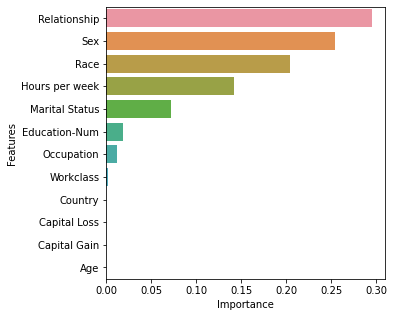

In [121]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 5))

In [122]:
y = (y_true).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
len(rules)

4

Rule 1 explains all instances classified $(False, True)$ of the original data set, except #925, which is explained by rule 2.

In [123]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

64     1
70     1
406    1
484    1
531    1
558    1
701    1
744    1
883    1
925    2
948    1
961    1
dtype: int64

In [124]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])

In [125]:
print_rules(rules, class_occurences)

1. Relationship <= 4.402771711349487 and Race > 3.5443339347839355 and Sex > 0.649721771478653 and `Hours per week` > 39.67813491821289 [2387, 3942]
2. `Marital Status` <= 2.47591769695282 and Relationship > 4.765960454940796 and Race > 3.481161594390869 and Sex <= 0.649721771478653 [84, 375]


#### Evaluation

##### Global Fidelity

In [126]:
evaluate(explanation, X, y_true)

              precision    recall  f1-score   support

           0       1.00      0.48      0.64       965
           1       0.02      1.00      0.05        12

    accuracy                           0.48       977
   macro avg       0.51      0.74      0.34       977
weighted avg       0.99      0.48      0.64       977



##### Counterfactual Fidelity Error

In [127]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

invalid value encountered in true_divide


In [128]:
rmse

Age                    NaN
Workclass              NaN
Education-Num          NaN
Marital Status    0.475918
Occupation             NaN
Relationship      2.012239
Race              2.324163
Sex               0.649722
Capital Gain           NaN
Capital Loss           NaN
Hours per week    0.678135
Country                NaN
dtype: float64

In [129]:
boundary_miss_rate

Age               1.000000
Workclass         1.000000
Education-Num     1.000000
Marital Status    0.916667
Occupation        1.000000
Relationship      0.473684
Race              0.000000
Sex               0.000000
Capital Gain      1.000000
Capital Loss      1.000000
Hours per week    0.541667
Country           1.000000
dtype: float64

In [130]:
boundary_add_rate

Age                    NaN
Workclass              NaN
Education-Num          NaN
Marital Status    0.000000
Occupation             NaN
Relationship      0.166667
Race              0.000000
Sex               0.250000
Capital Gain           NaN
Capital Loss           NaN
Hours per week    0.000000
Country                NaN
dtype: float64

##### Complexity

In [131]:
print_complexity(constraints)

Number of rules: 2
Number of constraints: 8 (4.0 per rule)


##### Stability

In [132]:
with open('explanation-diro2c-orig-01-global.pickle', 'wb') as f:
    pickle.dump((rules, constraints, instance_indices_per_rule), f)

### Local Explanations

In [133]:
%%time
train_surrogate_tree(explanation, max_depth=12)

CPU times: user 47.6 ms, sys: 2.75 ms, total: 50.4 ms
Wall time: 56.5 ms


In [134]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.98      0.96      0.97      7944
           1       0.93      0.96      0.95      4797

    accuracy                           0.96     12741
   macro avg       0.95      0.96      0.96     12741
weighted avg       0.96      0.96      0.96     12741



In [135]:
evaluate(explanation, X, y_true)

              precision    recall  f1-score   support

           0       1.00      0.90      0.95       965
           1       0.11      1.00      0.20        12

    accuracy                           0.90       977
   macro avg       0.56      0.95      0.57       977
weighted avg       0.99      0.90      0.94       977



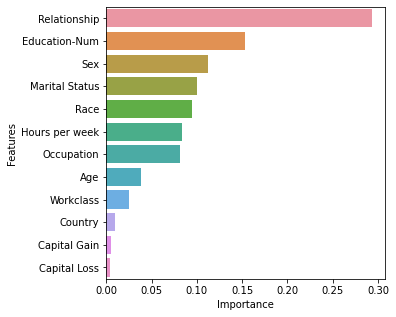

In [136]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 5))

In [137]:
y = (y_true).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
len(rules)

156

Rule 1 explains all instances classified $(False, True)$ of the original data set, except #925, which is explained by rule 2.

In [138]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

64     1
70     2
406    1
484    1
531    3
558    3
701    1
744    1
883    2
925    4
948    1
961    1
dtype: int64

In [139]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])

In [140]:
print_rules(rules, class_occurences)

1. Age > 44.64775276184082 and Workclass <= 5.149443626403809 and 8.688964366912842 < `Education-Num` <= 12.533215522766113 and `Marital Status` <= 2.5048539638519287 and Occupation <= 4.317143678665161 and 3.7380428314208984 < Relationship <= 4.402771711349487 and Race > 3.5443339347839355 and Sex > 0.649721771478653 and 39.67813491821289 < `Hours per week` <= 41.526845932006836 [236, 2434]
2. Age > 27.72172451019287 and Workclass <= 5.149443626403809 and `Education-Num` > 12.502001285552979 and `Marital Status` <= 2.5048539638519287 and Occupation > 4.317143678665161 and 3.7380428314208984 < Relationship <= 4.402771711349487 and Race > 3.5443339347839355 and Sex > 0.649721771478653 and 39.67813491821289 < `Hours per week` <= 41.526845932006836 [65, 671]
3. Age > 37.10478210449219 and Workclass <= 5.409208297729492 and `Education-Num` > 13.928133964538574 and `Marital Status` <= 5.873736619949341 and Occupation > 9.492910385131836 and Relationship <= 0.5058151483535767 and Race > 3.54

#### Evaluation

##### Global Fidelity

In [141]:
evaluate(explanation, X, y_true)

              precision    recall  f1-score   support

           0       1.00      0.90      0.95       965
           1       0.11      1.00      0.20        12

    accuracy                           0.90       977
   macro avg       0.56      0.95      0.57       977
weighted avg       0.99      0.90      0.94       977



##### Counterfactual Fidelity Error

In [142]:
errors, rmse, boundary_miss_rate, boundary_add_rate = \
    evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

invalid value encountered in true_divide


In [143]:
rmse

Age                  5.611577
Workclass            0.220723
Education-Num        1.240652
Marital Status       0.579354
Occupation           1.600959
Relationship         0.612859
Race                 2.324163
Sex                  0.649722
Capital Gain      2927.750977
Capital Loss              NaN
Hours per week       2.002719
Country              0.573923
dtype: float64

In [144]:
boundary_miss_rate

Age               0.458333
Workclass         0.450000
Education-Num     0.173913
Marital Status    0.000000
Occupation        0.478261
Relationship      0.000000
Race              0.000000
Sex               0.000000
Capital Gain      0.923077
Capital Loss      1.000000
Hours per week    0.000000
Country           0.909091
dtype: float64

In [145]:
boundary_add_rate

Age               0.000000
Workclass         0.000000
Education-Num     0.000000
Marital Status    0.000000
Occupation        0.000000
Relationship      0.095238
Race              0.000000
Sex               0.250000
Capital Gain      0.000000
Capital Loss           NaN
Hours per week    0.000000
Country           0.000000
dtype: float64

##### Complexity

In [146]:
print_complexity(constraints)

Number of rules: 4
Number of constraints: 45 (11.2 per rule)


##### Stability

In [147]:
with open('explanation-diro2c-orig-01-local.pickle', 'wb') as f:
    pickle.dump((rules, constraints, instance_indices_per_rule), f)